In [1]:
from typing import List, Tuple
import torch
from torch import nn, autograd, Tensor
from torch.nn import functional as F

import json
from pathlib import Path
import random
from time import time
import scipy
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from tqdm import tqdm

In [2]:
def calc_grad(y, x) -> Tensor:
    grad = autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad

class BurgersPiNN(nn.Module):
    """
    Burger's is in 1D, inputs are x, t.
    As opposed to 3D Navier-Stokes which has inputs x, y, t
    """
    def __init__(self, hidden_dims: List[int], nu: float):
        super(BurgersPiNN, self).__init__()
        self.hidden_dims = hidden_dims
        self.nu = nu # diffusion term
        self.ffn_layers = []
        input_dim = 2 # inputs are x, t
        for hidden_dim in hidden_dims:
            self.ffn_layers.append(nn.Linear(input_dim, hidden_dim))
            self.ffn_layers.append(nn.Tanh())
            self.ffn_layers.append(nn.BatchNorm1d(hidden_dim))
            input_dim = hidden_dim
        self.ffn_layers.append(nn.Linear(input_dim, 1)) # output is u
        self.ffn = nn.Sequential(*self.ffn_layers)
        
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x: Tensor, t: Tensor, u: Tensor = None):
        inputs = torch.stack([x, t], dim=1)
        u_pred = self.ffn(inputs).squeeze(1)
        
        # compute gradients
        u_t = calc_grad(u_pred, t)
        u_x = calc_grad(u_pred, x)
        u_xx = calc_grad(u_x, x)
        
        # Burger's PDE
        f_u = u_t + u_pred * u_x - self.nu * u_xx
        
        loss = None
        if u is not None:
            loss = self.loss_fn(u, u_pred, f_u)
        
        return {
            "u_pred": u_pred,
            "f_u": f_u,
            "loss": loss
        }
    
    def loss_fn(self, u, u_pred, f_u_pred):
        loss = (
            F.mse_loss(u, u_pred, reduction="sum")
            + F.mse_loss(f_u_pred, torch.zeros_like(f_u_pred), reduction="sum")
        )
        return loss

In [3]:
class BurgersPiNNDataset(Dataset):
    def __init__(self, data: np.ndarray):
        self.data = data
        self.examples = torch.tensor(
            data, dtype=torch.float32, requires_grad=True
        )
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        headers = ["t", "x", "u"]
        return {key: self.examples[idx, i] for i, key in enumerate(headers)}

def load_jsonl(path, skip_first_lines: int = 0):
    with open(path, "r") as f:
        for _ in range(skip_first_lines):
            next(f)
        return [json.loads(line) for line in f]


def dump_json(path, data):
    with open(path, "w") as f:
        json.dump(data, f, indent=4)


def get_dataset(data_path: Path) -> Tuple[BurgersPiNNDataset, BurgersPiNNDataset]:
    data = load_jsonl(data_path, skip_first_lines=1)
    random.shuffle(data)

    split_idx = int(len(data) * 0.9)
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    train_data = BurgersPiNNDataset(np.array(train_data))
    test_data = BurgersPiNNDataset(np.array(test_data))
    return train_data, test_data

def analytical_solution(x, t, U=1.0, alpha=0.01, k=np.pi):
    return U * np.exp(-alpha * k**2 * t) * np.sin(k * x)

def generate_burgers_data(num_points: int, nu: float=0.01, U=1.0, alpha=0.01, k=np.pi):
    x = np.linspace(-1, 1, num_points)
    t = np.linspace(0, 1, num_points)
    X, T = np.meshgrid(x, t)
    X_flat = X.flatten()
    T_flat = T.flatten()
    
    # compute solution using the analytical function
    U_flat = analytical_solution(X_flat, T_flat, U=U, alpha=alpha, k=k)

    # add noise
    #U_flat += 0.01 * np.random.randn(*U_flat.shape)

    data = np.vstack((T_flat, X_flat, U_flat)).T
    return data

def get_burgers_dataset(num_points: int = 10000) -> Tuple[BurgersPiNNDataset, BurgersPiNNDataset]:
    data  = generate_burgers_data(num_points)
    np.random.shuffle(data)
    
    split_idx = int(len(data) * 0.85)
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    train_data = BurgersPiNNDataset(train_data)
    test_data = BurgersPiNNDataset(test_data)
    return train_data, test_data

In [4]:
class Trainer:
    def __init__(self, model: BurgersPiNN):
        self.model = model
        
        # hyperparameters
        self.lr = 0.001
        self.lr_step = 1
        self.lr_gamma = 0.5
        self.num_epochs = 5
        self.batch_size = 256
        self.log_interval = 5
        self.samples_per_epoch = 10000
        
        # for checkpointing
        self.output_dir = Path(
            "result_Burgers",
            f"pinn-bs{self.batch_size}-lr{self.lr}-lrstep{self.lr_step}"
            f"-lrgamma{self.lr_gamma}-epoch{self.num_epochs}",
        )

        print(f"Output dir: {self.output_dir}")
        self.output_dir.mkdir(parents=True, exist_ok=True)
        args = {}
        for attr in ["lr", "lr_step", "lr_gamma", "num_epochs", "batch_size"]:
            args[attr] = getattr(self, attr)
        dump_json(self.output_dir / "args.json", args)

        # device, optimizer, learning rate, scheduler
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=100, gamma=0.5
        )
        
        self.loss_history = []
        
    def get_last_ckpt_dir(self) -> Path:
        ckpts = list(self.output_dir.glob("ckpt-*"))
        if len(ckpts) == 0:
            return None
        return sorted(ckpts)[-1]

    def train(self, train_data: BurgersPiNNDataset):
        model = self.model
        device = self.device
        
        sampler = RandomSampler(
            train_data, replacement=True, num_samples=self.samples_per_epoch
        )
        train_loader = DataLoader(
            train_data, batch_size=self.batch_size, sampler=sampler
        )
        
        print("====== Training ======")
        print(f"# epochs: {self.num_epochs}")
        print(f"# examples: {len(train_data)}")
        print(f"# samples used per epoch: {self.samples_per_epoch}")
        print(f"batch size: {self.batch_size}")
        print(f"# steps: {len(train_loader)}")
        loss_history = []
        
        model.train()
        model.to(device)
        
        # resume training from a checkpoint
        last_ckpt_dir = self.get_last_ckpt_dir()
        if last_ckpt_dir is not None:
            print(f"Resuming from {last_ckpt_dir}")
            model.load_state_dict(torch.load(last_ckpt_dir / "ckpt.pt"))
            self.optimizer.load_state_dict(
                torch.load(last_ckpt_dir / "optimizer.pt")
            )
            self.lr_scheduler.load_state_dict(
                torch.load(last_ckpt_dir / "lr_scheduler.pt")
            )
            ep = int(last_ckpt_dir.name.split("-")[-1]) + 1
        else:
            ep = 0
        
        train_start_time = time()
        losses_x_neg = []
        losses_x_pos = []
        
        while ep < self.num_epochs:
            print(f"====== Epoch {ep} ======")
            for step, batch in tqdm(enumerate(train_loader)):
                x_batch, t_batch, u_batch = batch["x"].to(device), batch["t"].to(device), batch["u"].to(device)
                
                x_values = x_batch.cpu().detach().numpy()
                neg_count = (x_values < 0).sum()
                pos_count = (x_values >= 0).sum()
                #print(f"Epoch {ep}, Batch x values: {x_values}, Neg count: {neg_count}, Pos count: {pos_count}")
                
                self.optimizer.zero_grad()
                
                # forward
                outputs = model(x_batch, t_batch, u_batch)
                loss = outputs["loss"]
                loss_history.append(loss.item())
                
                # backward
                loss.backward()
                self.optimizer.step()
                
                # Log separate losses for visualization
                if neg_count > 0:
                    losses_x_neg.append(loss.item())
                if pos_count > 0:
                    losses_x_pos.append(loss.item())
                
                if step % self.log_interval == 0:
                    print(
                        {
                            "step": step,
                            "loss": round(loss.item(), 6),
                            "loss_x_neg": losses_x_neg[-1],
                            "loss_y_pos": losses_x_pos[-1],
                            "lr": round(self.optimizer.param_groups[0]["lr"], 4),
                            "time": round(time() - train_start_time, 1),
                        }
                    )
            self.lr_scheduler.step()
            self.checkpoint(ep)
            print(f"====== Epoch {ep} done ======")
            ep += 1
        print("====== Training done ======")
        
        # Plotting the losses
        plt.plot(losses_x_neg, label='Loss for x < 0')
        plt.plot(losses_x_pos, label='Loss for x >= 0')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs for Different Regions')
        plt.legend()
        plt.show()
    
    def checkpoint(self, ep: int):
        """
        Dump checkpoint (model, optimizer, lr_scheduler) to "ckpt-{ep}" in
        the `output_dir`,

        and dump `self.loss_history` to "loss_history.json" in the
        `ckpt_dir`, and clear `self.loss_history`.
        """
        # Evaluate and save
        ckpt_dir = self.output_dir / f"ckpt-{ep}"
        ckpt_dir.mkdir(parents=True, exist_ok=True)
        print(f"Checkpointing to {ckpt_dir}")
        torch.save(self.model.state_dict(), ckpt_dir / "ckpt.pt")
        torch.save(self.optimizer.state_dict(), ckpt_dir / "optimizer.pt")
        torch.save(self.lr_scheduler.state_dict(), ckpt_dir / "lr_scheduler.pt")
        dump_json(ckpt_dir / "loss_history.json", self.loss_history)
        self.loss_history = []
    
    def predict(self, test_data: BurgersPiNNDataset) -> dict:
        batch_size = self.batch_size
        test_loader = DataLoader(
            test_data, batch_size=batch_size, shuffle=False
        )
        
        print("====== Testing ======")
        print(f"# examples: {len(test_data)}")
        print(f"batch size: {batch_size}")
        print(f"# steps: {len(test_loader)}")
        
        self.model.to(self.device)
        self.model.eval()
        
        all_preds = []
        all_losses = []
        
        for step, batch in tqdm(enumerate(test_loader)):
            x_batch, t_batch = batch["x"].to(self.device), batch["t"].to(self.device)
            
            outputs = self.model(x_batch, t_batch)
            f_u = outputs["f_u"]
            all_preds.append(outputs["u_pred"])
            
            # compute residual-based loss
            loss = F.mse_loss(f_u, torch.zeros_like(f_u), reduction="sum")
            all_losses.append(loss.item())
            
        print("====== Testing done ======")
        all_preds = torch.cat(all_preds, 0)
        loss = sum(all_losses) / len(all_losses)
        return {
            "loss": loss,
            "preds": all_preds
        }

In [5]:
torch.random.manual_seed(0)
random.seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# model
hidden_dims = [20] * 8
model = BurgersPiNN(hidden_dims=hidden_dims, nu=0.01)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Using device: cuda
Number of parameters: 3341


In [6]:
# data
train_data, test_data = get_burgers_dataset()

Output dir: result_Burgers/pinn-bs256-lr0.001-lrstep1-lrgamma0.5-epoch5
====== Training ======
# epochs: 5
# examples: 85000000
# samples used per epoch: 10000
batch size: 256
# steps: 40
====== Epoch 0 ======


1it [01:49, 109.51s/it]

{'step': 0, 'loss': 504.058929, 'loss_x_neg': 504.0589294433594, 'loss_y_pos': 504.0589294433594, 'lr': 0.001, 'time': 109.5}


6it [10:57, 109.37s/it]

{'step': 5, 'loss': 43.311134, 'loss_x_neg': 43.311134338378906, 'loss_y_pos': 43.311134338378906, 'lr': 0.001, 'time': 657.4}


11it [20:03, 109.23s/it]

{'step': 10, 'loss': 23.495062, 'loss_x_neg': 23.49506187438965, 'loss_y_pos': 23.49506187438965, 'lr': 0.001, 'time': 1203.4}


16it [29:09, 109.21s/it]

{'step': 15, 'loss': 16.521221, 'loss_x_neg': 16.521221160888672, 'loss_y_pos': 16.521221160888672, 'lr': 0.001, 'time': 1749.4}


21it [38:15, 109.19s/it]

{'step': 20, 'loss': 11.482031, 'loss_x_neg': 11.482030868530273, 'loss_y_pos': 11.482030868530273, 'lr': 0.001, 'time': 2295.3}


26it [47:21, 109.21s/it]

{'step': 25, 'loss': 14.015148, 'loss_x_neg': 14.015148162841797, 'loss_y_pos': 14.015148162841797, 'lr': 0.001, 'time': 2841.4}


31it [56:27, 109.19s/it]

{'step': 30, 'loss': 10.315323, 'loss_x_neg': 10.315322875976562, 'loss_y_pos': 10.315322875976562, 'lr': 0.001, 'time': 3387.3}


36it [1:05:33, 109.18s/it]

{'step': 35, 'loss': 6.793698, 'loss_x_neg': 6.793698310852051, 'loss_y_pos': 6.793698310852051, 'lr': 0.001, 'time': 3933.2}


40it [1:11:07, 106.69s/it]


Checkpointing to result_Burgers/pinn-bs256-lr0.001-lrstep1-lrgamma0.5-epoch5/ckpt-0
====== Epoch 0 done ======
====== Epoch 1 ======


1it [01:49, 109.20s/it]

{'step': 0, 'loss': 4.432625, 'loss_x_neg': 4.4326252937316895, 'loss_y_pos': 4.4326252937316895, 'lr': 0.001, 'time': 4376.8}


6it [10:55, 109.18s/it]

{'step': 5, 'loss': 3.31404, 'loss_x_neg': 3.314039707183838, 'loss_y_pos': 3.314039707183838, 'lr': 0.001, 'time': 4922.7}


11it [20:01, 109.19s/it]

{'step': 10, 'loss': 6.830685, 'loss_x_neg': 6.830684661865234, 'loss_y_pos': 6.830684661865234, 'lr': 0.001, 'time': 5468.7}


16it [29:07, 109.20s/it]

{'step': 15, 'loss': 17.324989, 'loss_x_neg': 17.324989318847656, 'loss_y_pos': 17.324989318847656, 'lr': 0.001, 'time': 6014.7}


21it [38:12, 109.19s/it]

{'step': 20, 'loss': 3.002655, 'loss_x_neg': 3.002655267715454, 'loss_y_pos': 3.002655267715454, 'lr': 0.001, 'time': 6560.6}


26it [47:18, 109.20s/it]

{'step': 25, 'loss': 4.194981, 'loss_x_neg': 4.194980621337891, 'loss_y_pos': 4.194980621337891, 'lr': 0.001, 'time': 7106.5}


31it [56:24, 109.20s/it]

{'step': 30, 'loss': 2.99191, 'loss_x_neg': 2.991910457611084, 'loss_y_pos': 2.991910457611084, 'lr': 0.001, 'time': 7652.5}


36it [1:05:30, 109.21s/it]

{'step': 35, 'loss': 2.55873, 'loss_x_neg': 2.558730363845825, 'loss_y_pos': 2.558730363845825, 'lr': 0.001, 'time': 8198.5}


40it [1:11:05, 106.63s/it]


Checkpointing to result_Burgers/pinn-bs256-lr0.001-lrstep1-lrgamma0.5-epoch5/ckpt-1
====== Epoch 1 done ======
====== Epoch 2 ======


1it [01:49, 109.17s/it]

{'step': 0, 'loss': 1.866998, 'loss_x_neg': 1.8669977188110352, 'loss_y_pos': 1.8669977188110352, 'lr': 0.001, 'time': 8642.1}


6it [10:55, 109.20s/it]

{'step': 5, 'loss': 4.781638, 'loss_x_neg': 4.781638145446777, 'loss_y_pos': 4.781638145446777, 'lr': 0.001, 'time': 9188.1}


11it [20:01, 109.21s/it]

{'step': 10, 'loss': 2.616898, 'loss_x_neg': 2.6168980598449707, 'loss_y_pos': 2.6168980598449707, 'lr': 0.001, 'time': 9734.3}


16it [29:06, 109.04s/it]

{'step': 15, 'loss': 6.032969, 'loss_x_neg': 6.0329694747924805, 'loss_y_pos': 6.0329694747924805, 'lr': 0.001, 'time': 10279.6}


21it [38:11, 108.97s/it]

{'step': 20, 'loss': 3.089488, 'loss_x_neg': 3.0894880294799805, 'loss_y_pos': 3.0894880294799805, 'lr': 0.001, 'time': 10824.3}


26it [47:16, 108.94s/it]

{'step': 25, 'loss': 1.858872, 'loss_x_neg': 1.8588718175888062, 'loss_y_pos': 1.8588718175888062, 'lr': 0.001, 'time': 11369.0}


31it [56:20, 108.93s/it]

{'step': 30, 'loss': 3.627474, 'loss_x_neg': 3.627474069595337, 'loss_y_pos': 3.627474069595337, 'lr': 0.001, 'time': 11913.7}


36it [1:05:25, 108.97s/it]

{'step': 35, 'loss': 1.912581, 'loss_x_neg': 1.9125808477401733, 'loss_y_pos': 1.9125808477401733, 'lr': 0.001, 'time': 12458.6}


40it [1:10:59, 106.48s/it]


Checkpointing to result_Burgers/pinn-bs256-lr0.001-lrstep1-lrgamma0.5-epoch5/ckpt-2
====== Epoch 2 done ======
====== Epoch 3 ======


1it [01:48, 108.91s/it]

{'step': 0, 'loss': 4.864593, 'loss_x_neg': 4.864592552185059, 'loss_y_pos': 4.864592552185059, 'lr': 0.001, 'time': 12901.2}


6it [10:53, 108.94s/it]

{'step': 5, 'loss': 3.190367, 'loss_x_neg': 3.190366744995117, 'loss_y_pos': 3.190366744995117, 'lr': 0.001, 'time': 13446.0}


11it [19:58, 108.94s/it]

{'step': 10, 'loss': 1.738026, 'loss_x_neg': 1.7380263805389404, 'loss_y_pos': 1.7380263805389404, 'lr': 0.001, 'time': 13990.7}


16it [29:03, 108.96s/it]

{'step': 15, 'loss': 5.19067, 'loss_x_neg': 5.190669536590576, 'loss_y_pos': 5.190669536590576, 'lr': 0.001, 'time': 14535.6}


21it [38:08, 108.96s/it]

{'step': 20, 'loss': 3.090025, 'loss_x_neg': 3.0900254249572754, 'loss_y_pos': 3.0900254249572754, 'lr': 0.001, 'time': 15080.4}


26it [47:12, 108.95s/it]

{'step': 25, 'loss': 3.791458, 'loss_x_neg': 3.7914576530456543, 'loss_y_pos': 3.7914576530456543, 'lr': 0.001, 'time': 15625.1}


31it [56:17, 108.93s/it]

{'step': 30, 'loss': 3.47206, 'loss_x_neg': 3.472059726715088, 'loss_y_pos': 3.472059726715088, 'lr': 0.001, 'time': 16169.7}


36it [1:05:22, 108.92s/it]

{'step': 35, 'loss': 1.537801, 'loss_x_neg': 1.5378007888793945, 'loss_y_pos': 1.5378007888793945, 'lr': 0.001, 'time': 16714.3}


40it [1:10:55, 106.40s/it]


Checkpointing to result_Burgers/pinn-bs256-lr0.001-lrstep1-lrgamma0.5-epoch5/ckpt-3
====== Epoch 3 done ======
====== Epoch 4 ======


1it [01:48, 108.85s/it]

{'step': 0, 'loss': 7.0468, 'loss_x_neg': 7.046800136566162, 'loss_y_pos': 7.046800136566162, 'lr': 0.001, 'time': 17157.0}


6it [10:53, 108.87s/it]

{'step': 5, 'loss': 3.913975, 'loss_x_neg': 3.9139747619628906, 'loss_y_pos': 3.9139747619628906, 'lr': 0.001, 'time': 17701.4}


11it [19:57, 108.90s/it]

{'step': 10, 'loss': 1.80029, 'loss_x_neg': 1.8002903461456299, 'loss_y_pos': 1.8002903461456299, 'lr': 0.001, 'time': 18245.9}


16it [29:02, 108.87s/it]

{'step': 15, 'loss': 2.515921, 'loss_x_neg': 2.515921115875244, 'loss_y_pos': 2.515921115875244, 'lr': 0.001, 'time': 18790.2}


21it [38:06, 108.88s/it]

{'step': 20, 'loss': 5.344807, 'loss_x_neg': 5.344807147979736, 'loss_y_pos': 5.344807147979736, 'lr': 0.001, 'time': 19334.6}


26it [47:10, 108.88s/it]

{'step': 25, 'loss': 4.637273, 'loss_x_neg': 4.637272834777832, 'loss_y_pos': 4.637272834777832, 'lr': 0.001, 'time': 19879.1}


31it [56:15, 108.87s/it]

{'step': 30, 'loss': 2.653798, 'loss_x_neg': 2.6537976264953613, 'loss_y_pos': 2.6537976264953613, 'lr': 0.001, 'time': 20423.4}


36it [1:05:19, 108.91s/it]

{'step': 35, 'loss': 3.365175, 'loss_x_neg': 3.365175485610962, 'loss_y_pos': 3.365175485610962, 'lr': 0.001, 'time': 20968.1}


40it [1:10:53, 106.34s/it]

Checkpointing to result_Burgers/pinn-bs256-lr0.001-lrstep1-lrgamma0.5-epoch5/ckpt-4
====== Epoch 4 done ======
====== Training done ======


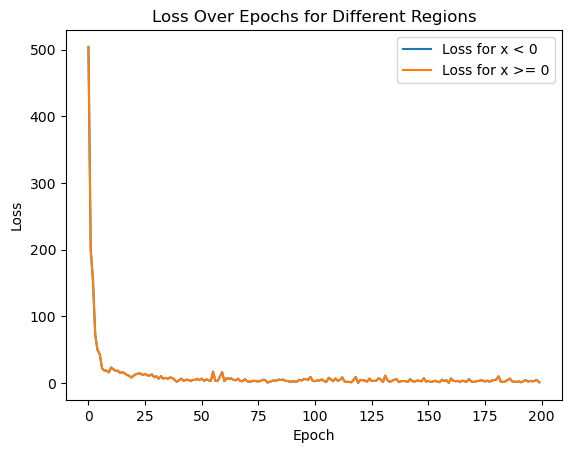

In [7]:
# train model
trainer = Trainer(model)
trainer.train(train_data)

In [8]:
# predict
predictions = trainer.predict(test_data)

====== Testing ======
# examples: 15000000
batch size: 256
# steps: 58594


58594it [20:38, 47.30it/s]


====== Testing done ======


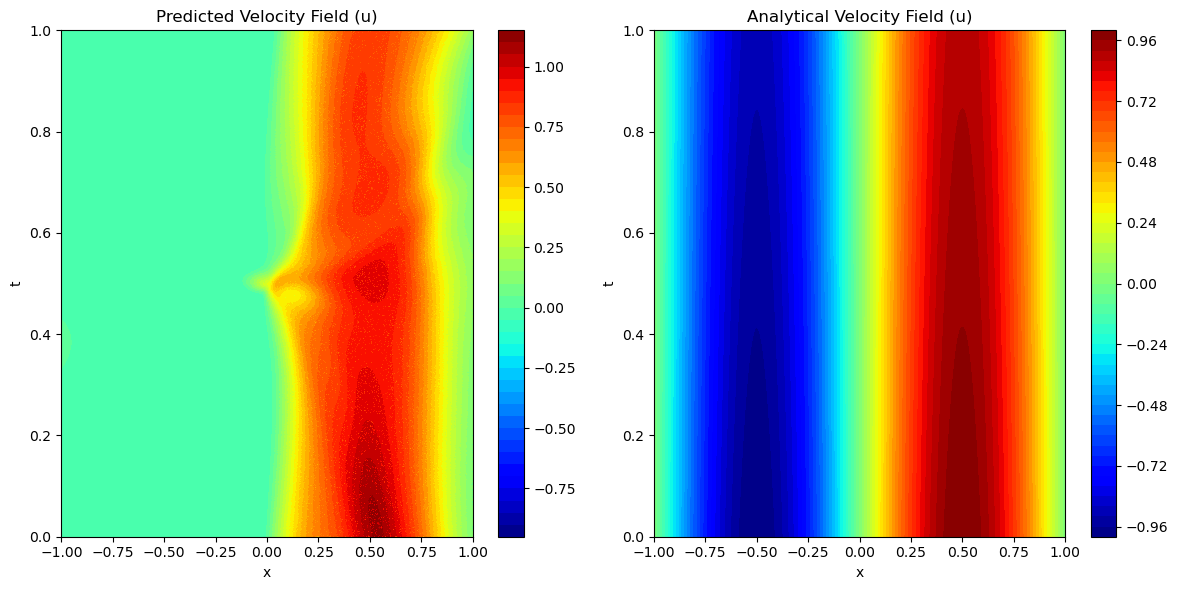

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the analytical solution
def analytical_solution(x, t, U=1.0, alpha=0.01, k=np.pi):
    return U * np.exp(-alpha * k**2 * t) * np.sin(k * x)

# Extracting predictions
u_pred = predictions['preds'].cpu().detach().numpy()

# Assuming the test data contains the inputs x and t in the same order as the predictions
x_test = test_data.examples[:, 1].cpu().detach().numpy()  # x values
t_test = test_data.examples[:, 0].cpu().detach().numpy()  # t values

# Reshape the data for plotting
x_unique = np.unique(x_test)
t_unique = np.unique(t_test)
X, T = np.meshgrid(x_unique, t_unique)

# Interpolate the predictions to the grid
U_pred_grid = np.zeros(X.shape)
for i in range(len(x_test)):
    xi = np.where(x_unique == x_test[i])[0][0]
    ti = np.where(t_unique == t_test[i])[0][0]
    U_pred_grid[ti, xi] = u_pred[i]

# Compute the analytical solution on the same grid
U_analytical_grid = analytical_solution(X, T)

# Visualization

# Contour plot of the predicted velocity field
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
contour_pred = plt.contourf(X, T, U_pred_grid, levels=50, cmap='jet')
plt.colorbar(contour_pred)
plt.title('Predicted Velocity Field (u)')
plt.xlabel('x')
plt.ylabel('t')

# Contour plot of the analytical velocity field
plt.subplot(1, 2, 2)
contour_analytical = plt.contourf(X, T, U_analytical_grid, levels=50, cmap='jet')
plt.colorbar(contour_analytical)
plt.title('Analytical Velocity Field (u)')
plt.xlabel('x')
plt.ylabel('t')

plt.tight_layout()
plt.show()